# **Môdulo principal do trabalho**
O programa abaixo implementa a lógica de paralelismo com 5 threads para processar as 1000 páginas de biografia mais rapidamente. Sem o uso do paralelismo demora muitas horas a mais, quando testei a diferença entre os processamentos paralelo e não paralelo obtive os seguintes resultados:

- Processamento Paralelo:17 minutos
- SEM Processamento Paralelo: 5h21 minutos

O programa possui os seguintes métodos:

- processPage:Processa a página recebida do crawler paralelo
- bioPage: Método de retorno booleano, indicando se a página recebida é uma página de biografia.
- extractValidLinks: Obtem os links presentes em uma página, limpa e retorna os links para a fila de processamento.
- savePage: Salva a página no diretório informado no inicio da execução do bloco.
- startParallelCrawler: Implementa toda a lógica do problema, gerencia e executa as filas juntamente a lógica paralela implementada.

In [9]:
!pip install networkx plotly pandas beautifulsoup4 dash dash-bootstrap-components anywidget

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.0 MB/s eta 0:00:0031m16.7 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.0/874.0 kB 16.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [10]:
# Bibliotecas padrão
import os
import re
import time
from collections import deque, defaultdict
from urllib.parse import unquote, urljoin, urldefrag

# Bibliotecas de terceiros
import ipywidgets as widgets
import networkx as nx
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import requests
from bs4 import BeautifulSoup
from IPython.display import display, HTML
from concurrent.futures import ThreadPoolExecutor, as_completed


BASE_URL = "https://pt.wikipedia.org"
INITIAL_PAGES = [
    "/wiki/Categoria:Nascidos_em_1990",
    "/wiki/Categoria:Mortos_em_2020",
    "/wiki/Categoria:Atores_do_Brasil",
]
SAVE_PATH = "bio_extract"
PAGES_TO_COLECT = 1000
MAX_THREADS = 5

HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

NOT_BIOGRAPHY_TITLE_KEYWORDS = [
    re.compile('estrela'),
    re.compile('partido político'),
    re.compile('álbum musical'),
    re.compile('gênero de'),
    re.compile('discografia de'),
    re.compile('matemática'),
    re.compile('governo de'),
    re.compile('religião'),
    re.compile('episódios de'),
    re.compile('constelação'),
    re.compile('coletânea de'),
    re.compile('empresa de'),
    re.compile('universidade de'),
    re.compile('cidades de'),
    re.compile('planeta'),
    re.compile('igreja de'),
    re.compile('software'),
    re.compile('mitologia'),
    re.compile('torneio de'),
    re.compile('geografia de'),
    re.compile('série de televisão'),
    re.compile('álbum ao vivo'),
    re.compile('futebol de'),
    re.compile('química'),
    re.compile('economia de'),
    re.compile('história de'),
    re.compile('anexo:'),
    re.compile('dialeto'),
    re.compile('filmes de'),
    re.compile('escola de'),
    re.compile('política de'),
    re.compile('lista de'),
    re.compile('prêmio'),
    re.compile('oscar de'),
    re.compile('ciência de'),
    re.compile('guerra de'),
    re.compile('álbum de'),
    re.compile('tecnologia de'),
    re.compile('espécie de'),
    re.compile('sistema de'),
    re.compile('física'),
    re.compile('biologia'),
    re.compile('mortes em'),
    re.compile('desaparecimento de'),
    re.compile('língua '),
    re.compile('campeonato de'),
]

BIOGRAPHY_KEYWORDS= [
    re.compile('apelido'),
    re.compile('mandato'),
    re.compile('profissão'),
    re.compile('nascimento'),
    re.compile('local de nascimento'),
    re.compile('publicações'),
    re.compile('anos ativo'),
    re.compile('filhos'),
    re.compile('ocupação'),
    re.compile('assinatura'),
    re.compile('trabalhos notáveis'),
    re.compile('peso'),
    re.compile('cônjuge'),
    re.compile('pais'),
    re.compile('falecimento'),
    re.compile('etnia'),
    re.compile('irmãos'),
    re.compile('religião'),
    re.compile('educação'),
    re.compile('carreira'),
    re.compile('local de falecimento'),
    re.compile('prêmios'),
    re.compile('títulos'),
    re.compile('residência'),
    re.compile('formação'),
    re.compile('cargo político'),
    re.compile('nacionalidade'),
    re.compile('conhecido(a) por'),
    re.compile('obras'),
    re.compile('partido político'),
    re.compile('distinções'),
    re.compile('orientação sexual'),
    re.compile('nome completo'),
    re.compile('sepultamento'),
    re.compile('alma mater'),
    re.compile('altura'),
    re.compile('governo'),
    re.compile('morte'),
    re.compile('filiações'),
]


NOT_BIOGRAPHY_KEYWORDS = [
    re.compile('continente'),
    re.compile('mapa'),
    re.compile('produtora'),
    re.compile('gravadora'),
    re.compile('integrantes'),
    re.compile('PIB'),
    re.compile('plataforma'),
    re.compile('população'),
    re.compile('finalização'),
    re.compile('fundado em'),
    re.compile('clube'),
    re.compile('artista'),
    re.compile('estado'),
    re.compile('gênero'),
    re.compile('moeda'),
    re.compile('uso'),
    re.compile('tipo'),
    re.compile('editora'),
    re.compile('sigla'),
    re.compile('bairro'),
    re.compile('público recorde'),
    re.compile('líder'),
    re.compile('inauguração'),
    re.compile('formato'),
    re.compile('capital'),
    re.compile('sede'),
    re.compile('espectro político'),
    re.compile('idioma oficial'),
    re.compile('temporada'),
    re.compile('altitude'),
    re.compile('competição'),
    re.compile('hino'),
    re.compile('diretor'),
    re.compile('fundação'),
    re.compile('divisão administrativa'),
    re.compile('localização'),
    re.compile('área'),
    re.compile('bandeira'),
    re.compile('escudo'),
    re.compile('website'),
    re.compile('temporadas'),
    re.compile('extensão'),
    re.compile('lançamento'),
    re.compile('coordenadas'),
    re.compile('sigla'),
    re.compile('religião'),
    re.compile('lema'),
    re.compile('estádio'),
    re.compile('país'),
    re.compile('ideologia'),
    re.compile('data'),
    re.compile('desenvolvedora'),
    re.compile('duração'),
    re.compile('canal'),
    re.compile('escudo'),
    re.compile('episódios'),
    re.compile('IDH'),
    re.compile('classificação'),
    re.compile('membros'),
    re.compile('detentor atual'),
    re.compile('município'),
    re.compile('capacidade'),
    re.compile('estreia'),
    re.compile('indústria'),
    re.compile('símbolo'),
]


BIOGRAPHY_PATTERNS= [
    re.compile('cientistas de'),
    re.compile('imperadores de'),
    re.compile('atores de'),
    re.compile('políticos de'),
    re.compile('prefeitos de'),
    re.compile('juízes de'),
    re.compile('cantores de'),
    re.compile('humoristas de'),
    re.compile('pintores de'),
    re.compile('santos de'),
    re.compile('generais de'),
    re.compile('apresentadores de televisão de'),
    re.compile('corredores de'),
    re.compile('monarcas de'),
    re.compile('advogados de'),
    re.compile('jornalistas de'),
    re.compile('músicos de'),
    re.compile('jogadores de basquetebol de'),
    re.compile('nascidos em'),
    re.compile('atrizes de'),
    re.compile('militares de'),
    re.compile('diretores de cinema de'),
    re.compile('ciclistas de'),
    re.compile('rabinos de'),
    re.compile('reis de'),
    re.compile('escritores de'),
    re.compile('papas'),
    re.compile('atletas de'),
    re.compile('presidentes de'),
    re.compile('religiosos de'),
    re.compile('dançarinos de'),
    re.compile('senadores de'),
    re.compile('modelos de'),
    re.compile('mortos em'),
    re.compile('filósofos de'),
    re.compile('governadores de'),
    re.compile('imãs de'),
    re.compile('rainhas de'),
    re.compile('chefes de cozinha de'),
    re.compile('jogadores de tênis de'),
    re.compile('naturais de'),
    re.compile('futebolistas de'),
    re.compile('produtores de'),
    re.compile('nadadores de'),
    re.compile('deputados de'),
]

def bioPage(soup):
    if soup.title and soup.title.string:
        title = soup.title.string.lower()
        if any(word.search(title) for word in NOT_BIOGRAPHY_TITLE_KEYWORDS):
            return False

    infobox = soup.select_one("table.infobox, table.vcard")
    if infobox:
        tableFields = {th.get_text(strip=True).lower() for th in infobox.find_all("th")}

        if any(p.search(field) for p in NOT_BIOGRAPHY_KEYWORDS for field in tableFields):
            return False

        if any(p.search(field) for p in BIOGRAPHY_KEYWORDS for field in tableFields):
            return True

    categoryBox = soup.find('div', id='catlinks')
    if categoryBox:
        categoryTexts = categoryBox.get_text().lower()
        if any(pattern.search(categoryTexts) for pattern in BIOGRAPHY_PATTERNS):
            return True

    return False

def extractValidLinks(soup):
    articleArea = soup.find("div", id="bodyContent")
    if not articleArea:
        return []

    findedLinks = articleArea.find_all("a", href=re.compile(r"^/wiki/[^:]+$"))
    cleanLinks = set()

    for link in findedLinks:
        href = link.get('href')
        if href:
            noFragmentoUrl = urldefrag(href).url
            cleanLinks.add(noFragmentoUrl)

    return list(cleanLinks)

def savePage(page_content, relative_name):
    baseName = relative_name.split('/')[-1]
    secBaseName = re.sub(r'[\\/*?:"<>|]', "_", baseName)
    file_path = os.path.join(SAVE_PATH, f"{secBaseName}.html")

    try:
        with open(file_path, "wb") as f:
            f.write(page_content)
        print(f"### [SavePage] Page Saved: '{file_path}'")
        return True
    except IOError as e:
        print(f"### [SavePage - ERROR] saving {file_path}: {e}")
        return False

def processPage(relative_page):
    completeUrl = urljoin(BASE_URL, relative_page)
    try:
        response = requests.get(completeUrl, headers=HEADERS, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")

        if bioPage(soup):
            print(f"[### ProcessPage - Bio] {completeUrl}")
            if savePage(response.content, relative_page):
                return ('bio', relative_page)
        else:
            newLinks = extractValidLinks(soup)
            return ('links', newLinks)

    except Exception as e:
        print(f"[### ProcessPage - ERROR] {completeUrl} - {e}")
    return (None, None)

def startParallelCrawler():
    linksToVisit = deque(INITIAL_PAGES)
    linksVisited = set(INITIAL_PAGES)
    savedBiographyPageCounter = 0
    visitedPagesCounter = 0

    os.makedirs(SAVE_PATH, exist_ok=True)
    print(f"\n### [Parallel Crawler] Iniciando o crawler com paralelismo ({MAX_THREADS} threads)\n")

    with ThreadPoolExecutor(max_workers=MAX_THREADS) as executor:
        while linksToVisit and savedBiographyPageCounter < PAGES_TO_COLECT:
            tarefas = {}
            while linksToVisit and len(tarefas) < MAX_THREADS:
                pagina = linksToVisit.popleft()
                tarefas[executor.submit(processPage, pagina)] = pagina

            for future in as_completed(tarefas):
                resultado, data = future.result()
                visitedPagesCounter += 1

                if resultado == 'bio':
                    savedBiographyPageCounter += 1
                    print(f"[### Parallel Crawler - Progresso] {savedBiographyPageCounter}/{PAGES_TO_COLECT} biographies saved.")
                elif resultado == 'links':
                    newLinksAdd = 0
                    for link in data:
                        if link not in linksVisited:
                            linksVisited.add(link)
                            linksToVisit.append(link)
                            newLinksAdd += 1
                    if newLinksAdd:
                        print(f"[### Parallel Crawler - LINKS] +{newLinksAdd} new links added")

    print("\n"+"===============")
    print("Crawler Done")
    print("===============")
    print(f"Total unique pages visited: {len(linksVisited)}")
    print(f"Total biographies colected: {savedBiographyPageCounter}")
    if visitedPagesCounter > 0:
        proportion = (savedBiographyPageCounter / visitedPagesCounter) * 100
        print(f"Proportion (Biographies founded / Analyzed Pages): {proportion:.2f}%")
    print(f"Biographies saved on folder: '{SAVE_PATH}'")

if __name__ == "__main__":
    startParallelCrawler()



### [Parallel Crawler] Iniciando o crawler com paralelismo (5 threads)

[### Parallel Crawler - LINKS] +204 new links added
[### Parallel Crawler - LINKS] +67 new links added
[### Parallel Crawler - LINKS] +201 new links added
[### ProcessPage - Bio] https://pt.wikipedia.org/wiki/Road_Warrior_Animal
[### ProcessPage - Bio] https://pt.wikipedia.org/wiki/Abraham_Palatnik
### [SavePage] Page Saved: 'bio_extract/Abraham_Palatnik.html'
[### Parallel Crawler - Progresso] 1/1000 biographies saved.
### [SavePage] Page Saved: 'bio_extract/Road_Warrior_Animal.html'
[### Parallel Crawler - Progresso] 2/1000 biographies saved.
[### ProcessPage - Bio] https://pt.wikipedia.org/wiki/Peter_Iornzuul_Adoboh
### [SavePage] Page Saved: 'bio_extract/Peter_Iornzuul_Adoboh.html'
[### Parallel Crawler - Progresso] 3/1000 biographies saved.
[### ProcessPage - Bio] https://pt.wikipedia.org/wiki/Arolde_de_Oliveira
[### Parallel Crawler - LINKS] +384 new links added
### [SavePage] Page Saved: 'bio_extract/Arolde

KeyboardInterrupt: 

# **Método auxiliar para limpar diretório**

Execute esse bloco apenas se você deseja limpar o diretório informado.

In [ ]:
import os

SAVE_PATH = "bio_extract"

def deleteHtmlFiles(directory=SAVE_PATH):
    if not os.path.exists(directory):
        print(f"[### DeleteFiles - ERROR] Folder '{directory}' doesn't exists.")
        return

    rmCount = 0
    for filename in os.listdir(directory):
        if filename.lower().endswith(".html"):
            filePath = os.path.join(directory, filename)
            try:
                os.remove(filePath)
                print(f"[### DeleteFiles - SUCCESS] {filePath}")
                rmCount += 1
            except Exception as e:
                print(f"[### DeleteFiles - ERROR] {filePath}: {e}")

    print(f"\nTotal HTML files removed: {rmCount}")

if __name__ == "__main__":
    deleteHtmlFiles()


[### DeleteFiles - SUCCESS] bio_extract/Adolfo_Celi.html
[### DeleteFiles - SUCCESS] bio_extract/Manuel_P%C3%AAra.html
[### DeleteFiles - SUCCESS] bio_extract/David_Jos%C3%A9.html
[### DeleteFiles - SUCCESS] bio_extract/T%C3%A2nia_Paes.html
[### DeleteFiles - SUCCESS] bio_extract/Felipe_Wagner.html
[### DeleteFiles - SUCCESS] bio_extract/Fernando_Neves.html
[### DeleteFiles - SUCCESS] bio_extract/Anthony_Steffen.html
[### DeleteFiles - SUCCESS] bio_extract/Chico_D%C3%ADaz.html
[### DeleteFiles - SUCCESS] bio_extract/Francisco_Dantas_(ator).html
[### DeleteFiles - SUCCESS] bio_extract/Eug%C3%AAnio_Kusnet.html
[### DeleteFiles - SUCCESS] bio_extract/Blaise_Musipere.html
[### DeleteFiles - SUCCESS] bio_extract/Charles_Paraventi.html
[### DeleteFiles - SUCCESS] bio_extract/Em%C3%ADlio_Doux.html
[### DeleteFiles - SUCCESS] bio_extract/Macedo_Neto.html
[### DeleteFiles - SUCCESS] bio_extract/Gilbert_(cantor).html
[### DeleteFiles - SUCCESS] bio_extract/Perfeito_Fortuna.html
[### DeleteFiles 

# **Môdulo de listagem de biografias coletadas**
Aqui serão lidos todos os arquivos .html dentro da pasta, atualmente configurada, ***bio_extract***.

Lista os nomes que poderão ser utilizados na parte 2.

In [11]:
import os
from bs4 import BeautifulSoup

SAVE_PATH = "bio_extract"

def extractTitleName(soup):
    if soup.title:
        completeTitle = soup.title.string
        return completeTitle.split('–')[0].strip()
    return None

def listBiographyNames():
    print(f"[### ListBio] Reading Files on: '{SAVE_PATH}'")

    try:
        htmlFiles = [f for f in os.listdir(SAVE_PATH) if f.endswith(".html")]
    except FileNotFoundError:
        print(f"\n[### ListBio - ERROR]: The folder'{SAVE_PATH}' was not founded.")
        return

    if not htmlFiles:
        print("\n[### ListBio - ERROR] No .html founded on folder.")
        return

    foundedNames = []
    for fileFound in htmlFiles:
        completePath = os.path.join(SAVE_PATH, fileFound)
        try:
            with open(completePath, 'r', encoding='utf-8') as f:
                soup = BeautifulSoup(f.read(), "html.parser")
                realName = extractTitleName(soup)
                if realName:
                    foundedNames.append(realName)
                else:
                    nameFallback = os.path.splitext(fileFound)[0].replace('_', ' ')
                    foundedNames.append(f"{nameFallback} (sem título)")
        except Exception as e:
            print(f"[### ListBio - ERROR] {fileFound}: {e}")

    foundedNames.sort()

    print(f"\Total biographies found {len(foundedNames)}:\n")
    for nome in foundedNames:
        print(f"- {nome}")

if __name__ == "__main__":
    listBiographyNames()

<>:42: SyntaxWarning: invalid escape sequence '\T'
<>:42: SyntaxWarning: invalid escape sequence '\T'
/tmp/ipykernel_7371/988853975.py:42: SyntaxWarning: invalid escape sequence '\T'
  print(f"\Total biographies found {len(foundedNames)}:\n")


[### ListBio] Reading Files on: 'bio_extract'
\Total biographies found 1004:

- 0 (número)
- A. G. Cook
- A.X.L.
- Aanchal Malhotra
- Aarón Hernán
- Abby Dalton
- Abderrahmane Youssoufi
- Abdul Halim Khaddam
- Abdurrahim El-Keib
- Abeba Aregawi
- Abel Nunes de Figueiredo
- Abraham Palatnik
- Abu Mahdi al-Muhandis
- Achille Lauro (cantor)
- Adalet Ağaoğlu
- Adam Kellerman
- Adam Schlesinger
- Adanilo
- Adaylton Freitas
- Adderly Fong
- Addy Valero
- Adelaide Chiozzo
- Adir Sodré
- Adolfo Celi
- Adolfo Nicolás
- Adrian Gomes
- Adriana Cardoso de Castro
- Adriana Maldonado López
- Adriano Aparecido Silva
- Adrianus Johannes Simonis
- Adrià Delgado
- Adrián Di Monte
- Affonso Arinos de Mello Franco
- Affonso Cândido
- Afonso Reis Cabral
- Agustín Alezzo
- Agustín Roberto Radrizzani
- Ahmad NikTalab
- Ahmed Al Mansoori
- Ahmed Patel
- Aida Kamel
- Aileen Baviera
- Akin Euba
- Akın Akınözü
- Alaaeldin Abouelkassem
- Aladim (político)
- Alain Bertrand
- Alain Erlande-Brandenburg
- Alan Traill

In [12]:
SAVE_PATH = "bio_extract"

class SixDegreesAnalyzer:
    def __init__(self, save_path=SAVE_PATH):
        self.save_path = save_path
        self.person_files = {}  # nome_pessoa -> arquivo
        self.connections = defaultdict(set)  # pessoa -> set de pessoas conectadas
        self.loaded = False
    
    def normalize_name(self, name):
        """Normaliza nomes para comparação (remove acentos, espaços extras, etc.)"""
        if not name:
            return ""
        # Remove conteúdo entre parênteses e traços
        name = re.sub(r'\([^)]*\)', '', name)
        name = re.sub(r'—.*', '', name)
        name = name.strip().lower()
        return name
    
    def extract_person_name_from_file(self, file_path):
        """Extrai o nome da pessoa de um arquivo HTML"""
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                soup = BeautifulSoup(f.read(), "html.parser")
                
                if soup.title:
                    title = soup.title.string
                    # Remove " – Wikipédia, a enciclopédia livre"
                    name = title.split('–')[0].strip()
                    return name
                    
        except Exception as e:
            print(f"Erro ao extrair nome de {file_path}: {e}")
        
        # Fallback: usar nome do arquivo
        filename = os.path.basename(file_path)
        name = os.path.splitext(filename)[0].replace('_', ' ')
        return name
    
    def extract_links_from_file(self, file_path):
        """Extrai links para outras páginas da Wikipedia de um arquivo HTML"""
        links = set()
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                soup = BeautifulSoup(f.read(), "html.parser")
                
                # Procura por links no conteúdo principal
                content_area = soup.find("div", id="bodyContent") or soup
                
                for link in content_area.find_all("a", href=re.compile(r"^/wiki/[^:]+$")):
                    href = link.get('href')
                    if href:
                        # Remove fragmentos da URL
                        clean_href = href.split('#')[0]
                        # Decodifica URL
                        decoded_href = unquote(clean_href)
                        # Extrai o nome da página
                        page_name = decoded_href.replace('/wiki/', '').replace('_', ' ')
                        links.add(page_name)
                        
        except Exception as e:
            print(f"Erro ao extrair links de {file_path}: {e}")
            
        return links
    
    def load_biographies_and_connections(self):
        """Carrega todas as biografias e constrói o grafo de conexões"""
        print(f"[SixDegrees] Carregando biografias de '{self.save_path}'...")
        
        if not os.path.exists(self.save_path):
            print(f"Erro: Pasta '{self.save_path}' não encontrada!")
            return False
        
        html_files = [f for f in os.listdir(self.save_path) if f.endswith('.html')]
        
        if not html_files:
            print("Erro: Nenhum arquivo HTML encontrado!")
            return False
        
        # Primeira passada: mapear nomes para arquivos
        print("Mapeando nomes das pessoas...")
        for filename in html_files:
            file_path = os.path.join(self.save_path, filename)
            person_name = self.extract_person_name_from_file(file_path)
            normalized_name = self.normalize_name(person_name)
            
            if normalized_name:
                self.person_files[normalized_name] = {
                    'original_name': person_name,
                    'filename': filename,
                    'file_path': file_path
                }
        
        print(f"Encontradas {len(self.person_files)} biografias.")
        
        # Segunda passada: construir conexões
        print("Construindo grafo de conexões...")
        connection_count = 0
        
        for normalized_name, person_info in self.person_files.items():
            file_path = person_info['file_path']
            links = self.extract_links_from_file(file_path)
            
            # Para cada link encontrado, verifica se corresponde a uma pessoa coletada
            for link in links:
                normalized_link = self.normalize_name(link)
                if normalized_link in self.person_files and normalized_link != normalized_name:
                    self.connections[normalized_name].add(normalized_link)
                    connection_count += 1
        
        print(f"Grafo construído com {connection_count} conexões.")
        self.loaded = True
        return True
    
    def find_path_bfs(self, start_person, end_person):
        """Usa BFS para encontrar o caminho mais curto entre duas pessoas"""
        start_normalized = self.normalize_name(start_person)
        end_normalized = self.normalize_name(end_person)
        
        # Verifica se ambas as pessoas existem
        if start_normalized not in self.person_files:
            return None, f"Pessoa '{start_person}' não encontrada nas biografias coletadas."
        
        if end_normalized not in self.person_files:
            return None, f"Pessoa '{end_person}' não encontrada nas biografias coletadas."
        
        if start_normalized == end_normalized:
            return [start_normalized], "Mesma pessoa!"
        
        # BFS
        queue = deque([(start_normalized, [start_normalized])])
        visited = {start_normalized}
        
        while queue:
            current_person, path = queue.popleft()
            
            # Verifica todas as conexões da pessoa atual
            for connected_person in self.connections[current_person]:
                if connected_person == end_normalized:
                    # Encontrou o destino!
                    final_path = path + [connected_person]
                    return final_path, None
                
                if connected_person not in visited:
                    visited.add(connected_person)
                    new_path = path + [connected_person]
                    queue.append((connected_person, new_path))
        
        return None, "Não há caminho entre essas duas pessoas nas biografias coletadas."
    
    def get_separation_degree(self, person1, person2):
        """Calcula o grau de separação entre duas pessoas"""
        if not self.loaded:
            if not self.load_biographies_and_connections():
                return None, "Erro ao carregar dados."
        
        path, error = self.find_path_bfs(person1, person2)
        
        if error:
            return None, error
        
        # O grau de separação é o número de "saltos" (conexões) no caminho
        degree = len(path) - 1
        
        return degree, path
    
    def format_result(self, person1, person2):
        """Formata o resultado da busca"""
        degree, path_or_error = self.get_separation_degree(person1, person2)
        
        if degree is None:
            return f"Erro: {path_or_error}"
        
        if degree == 0:
            return f"'{person1}' e '{person2}' são a mesma pessoa!"
        
        # Converte nomes normalizados de volta para nomes originais
        original_path = []
        for normalized_name in path_or_error:
            if normalized_name in self.person_files:
                original_path.append(self.person_files[normalized_name]['original_name'])
            else:
                original_path.append(normalized_name)
        
        result = f"\nGrau de separação entre '{person1}' e '{person2}': {degree}\n"
        result += "\nCaminho:\n"
        
        for i, person in enumerate(original_path):
            result += f"{i + 1}. {person}"
            if i < len(original_path) - 1:
                result += " → "
            result += "\n"
        
        return result
    
    def list_available_people(self, limit=50):
        """Lista as pessoas disponíveis para consulta"""
        if not self.loaded:
            if not self.load_biographies_and_connections():
                return "Erro ao carregar dados."
        
        people = [info['original_name'] for info in self.person_files.values()]
        people.sort()
        
        result = f"Pessoas disponíveis para consulta ({len(people)} total"
        if limit and len(people) > limit:
            result += f", mostrando primeiras {limit}"
        result += "):\n\n"
        
        display_people = people[:limit] if limit else people
        for i, person in enumerate(display_people, 1):
            result += f"{i:3d}. {person}\n"
        
        if limit and len(people) > limit:
            result += f"\n... e mais {len(people) - limit} pessoas."
        
        return result

def main():
    """Função principal para testar o sistema"""
    analyzer = SixDegreesAnalyzer()
    
    print("=== SISTEMA DE 6 GRAUS DE SEPARAÇÃO ===")
    print()
    
    while True:
        print("\nOpções:")
        print("1. Listar pessoas disponíveis")
        print("2. Encontrar grau de separação")
        print("3. Sair")
        
        choice = input("\nEscolha uma opção (1-3): ").strip()
        
        if choice == "1":
            print(analyzer.list_available_people())
        
        elif choice == "2":
            person1 = input("Digite o nome da primeira pessoa: ").strip()
            person2 = input("Digite o nome da segunda pessoa: ").strip()
            
            if person1 and person2:
                print(analyzer.format_result(person1, person2))
            else:
                print("Por favor, digite ambos os nomes.")
        
        elif choice == "3":
            print("Encerrando...")
            break
        
        else:
            print("Opção inválida!")

In [13]:
if __name__ == "__main__":
    analyzer = SixDegreesAnalyzer()
    
    print("=== TESTE RÁPIDO ===")
    print("Carregando dados...")
    
    if analyzer.load_biographies_and_connections():
        # Lista algumas pessoas disponíveis
        print("\nAlgumas pessoas disponíveis:")
        people_list = analyzer.list_available_people(limit=10)
        print(people_list)
        
        # Para testar, pode usar dois nomes da lista acima
        # Exemplo (descomente e ajuste os nomes):
        # print(analyzer.format_result("Nome Pessoa 1", "Nome Pessoa 2"))
        
        # Inicia interface interativa
        main()
    else:
        print("Erro ao carregar biografias. Verifique se o crawler foi executado e as páginas foram salvas.")


=== TESTE RÁPIDO ===
Carregando dados...
[SixDegrees] Carregando biografias de 'bio_extract'...
Mapeando nomes das pessoas...
Encontradas 1000 biografias.
Construindo grafo de conexões...
Grafo construído com 1440 conexões.

Algumas pessoas disponíveis:
Pessoas disponíveis para consulta (1000 total, mostrando primeiras 10):

  1. 0 (número)
  2. A. G. Cook
  3. A.X.L.
  4. Aanchal Malhotra
  5. Aarón Hernán
  6. Abby Dalton
  7. Abderrahmane Youssoufi
  8. Abdul Halim Khaddam
  9. Abdurrahim El-Keib
 10. Abeba Aregawi

... e mais 990 pessoas.
=== SISTEMA DE 6 GRAUS DE SEPARAÇÃO ===


Opções:
1. Listar pessoas disponíveis
2. Encontrar grau de separação
3. Sair



Escolha uma opção (1-3):  S


Opção inválida!

Opções:
1. Listar pessoas disponíveis
2. Encontrar grau de separação
3. Sair



Escolha uma opção (1-3):  3


Encerrando...


In [17]:


import os
import re
import networkx as nx
import plotly.graph_objects as go
from bs4 import BeautifulSoup
from urllib.parse import unquote
import numpy as np

SAVE_PATH = "bio_extract"

class SimpleGraphVisualizer:
    def __init__(self, save_path=SAVE_PATH):
        self.save_path = save_path
        self.person_files = {}
        self.graph = nx.Graph()
        self.loaded = False
        self.positions = {}
        self.selected_node = None

    def is_valid_biography(self, name):
        """Verifica se o nome representa uma biografia válida"""
        if not name:
            return False
        name_lower = name.lower().strip()
        invalid_patterns = [
            r'categoria:', r'lista de', r'anexo:', r'wikipédia:', 
            r'predefinição:', r'ficheiro:', r'imagem:', r'discussão:'
        ]
        return not any(re.search(pattern, name_lower) for pattern in invalid_patterns)

    def normalize_name(self, name):
        """Normaliza nomes para comparação"""
        if not name:
            return ""
        name = re.sub(r'\([^)]*\)', '', name)
        name = re.sub(r'—.*', '', name)
        return name.strip().lower()

    def extract_person_name_from_file(self, file_path):
        """Extrai o nome da pessoa de um arquivo HTML"""
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                soup = BeautifulSoup(f.read(), "html.parser")
                if soup.title and soup.title.string:
                    name = soup.title.string.split('–')[0].strip()
                    if self.is_valid_biography(name):
                        return name
        except Exception as e:
            print(f"Erro ao extrair nome de {file_path}: {e}")
        return None

    def extract_links_from_file(self, file_path):
        """Extrai links para outras páginas da Wikipedia"""
        links = set()
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                soup = BeautifulSoup(f.read(), "html.parser")
                content_area = soup.find("div", id="bodyContent") or soup
                
                for link in content_area.find_all("a", href=re.compile(r"^/wiki/[^:]+$")):
                    href = link.get('href')
                    if href:
                        page_name = unquote(href.split('#')[0]).replace('/wiki/', '').replace('_', ' ')
                        if self.is_valid_biography(page_name):
                            links.add(page_name)
        except Exception as e:
            print(f"Erro ao extrair links de {file_path}: {e}")
        return links

    def load_data(self):
        """Carrega todas as biografias e constrói o grafo"""
        if self.loaded:
            return True
            
        print(f"Carregando biografias de '{self.save_path}'...")
        if not os.path.exists(self.save_path):
            print(f"Erro: Pasta '{self.save_path}' não encontrada!")
            return False

        html_files = [f for f in os.listdir(self.save_path) if f.endswith('.html')]
        if not html_files:
            print("Erro: Nenhum arquivo HTML encontrado!")
            return False

        # Primeira passada: coletar pessoas
        for filename in html_files:
            file_path = os.path.join(self.save_path, filename)
            person_name = self.extract_person_name_from_file(file_path)
            if person_name:
                normalized_name = self.normalize_name(person_name)
                if normalized_name not in self.person_files:
                    self.person_files[normalized_name] = {
                        'original_name': person_name,
                        'file_path': file_path
                    }
                    self.graph.add_node(normalized_name, original_name=person_name)

        print(f"Encontradas {len(self.person_files)} pessoas")

        # Segunda passada: criar conexões
        for normalized_name, person_info in self.person_files.items():
            links = self.extract_links_from_file(person_info['file_path'])
            for link in links:
                normalized_link = self.normalize_name(link)
                if normalized_link in self.person_files and normalized_link != normalized_name:
                    self.graph.add_edge(normalized_name, normalized_link)

        print(f"Grafo criado: {self.graph.number_of_nodes()} nós, {self.graph.number_of_edges()} arestas")

        # Calcular posições
        if self.graph.number_of_nodes() > 0:
            try:
                if self.graph.number_of_nodes() < 50:
                    self.positions = nx.spring_layout(self.graph, k=2, iterations=50)
                else:
                    self.positions = nx.spring_layout(self.graph, k=1, iterations=30)
            except:
                # Fallback para layout mais simples
                self.positions = nx.random_layout(self.graph)

        self.loaded = True
        return True

    def create_visualization(self):
        """Cria a visualização básica do grafo"""
        if not self.load_data():
            return None

        # Preparar dados das arestas
        edge_x, edge_y = [], []
        for edge in self.graph.edges():
            if edge[0] in self.positions and edge[1] in self.positions:
                x0, y0 = self.positions[edge[0]]
                x1, y1 = self.positions[edge[1]]
                edge_x.extend([x0, x1, None])
                edge_y.extend([y0, y1, None])

        # Preparar dados dos nós
        node_x, node_y, node_text, node_degrees = [], [], [], []
        node_names = []

        for node in self.graph.nodes():
            if node in self.positions:
                x, y = self.positions[node]
                node_x.append(x)
                node_y.append(y)
                original_name = self.graph.nodes[node]['original_name']
                degree = self.graph.degree(node)
                node_text.append(f"{original_name}<br>Conexões: {degree}")
                node_degrees.append(degree)
                node_names.append(node)

        # Criar traces
        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=1, color='#888'),
            hoverinfo='none',
            mode='lines'
        )

        # Calcular tamanhos dos nós baseado no grau
        node_sizes = [max(5, min(15, degree)) for degree in node_degrees]

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers',
            hoverinfo='text',
            hovertext=node_text,
            marker=dict(
                size=node_sizes,
                color=node_degrees,
                colorscale='Blues',
                showscale=True,
                colorbar=dict(title="Conexões")
            )
        )

        # Criar figura
        fig = go.Figure(data=[edge_trace, node_trace])

        fig.update_layout(
            title='Grafo de Conexões - Versão Simplificada',
            titlefont_size=16,
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            annotations=[
                dict(
                    text="Clique e arraste para mover. Use zoom para explorar.",
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002,
                    xanchor='left', yanchor='bottom',
                    font=dict(size=12, color="#888")
                )
            ],
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
        )

        return fig

    def create_interactive_visualization(self):
        """Cria visualização interativa com clique"""
        if not self.load_data():
            return None

        # Preparar dados
        edge_x, edge_y = [], []
        for edge in self.graph.edges():
            if edge[0] in self.positions and edge[1] in self.positions:
                x0, y0 = self.positions[edge[0]]
                x1, y1 = self.positions[edge[1]]
                edge_x.extend([x0, x1, None])
                edge_y.extend([y0, y1, None])

        node_x, node_y, node_text, node_degrees = [], [], [], []
        node_names = []

        for node in self.graph.nodes():
            if node in self.positions:
                x, y = self.positions[node]
                node_x.append(x)
                node_y.append(y)
                original_name = self.graph.nodes[node]['original_name']
                degree = self.graph.degree(node)
                node_text.append(f"{original_name}<br>Conexões: {degree}")
                node_degrees.append(degree)
                node_names.append(node)

        # Traces iniciais
        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines'
        )

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers',
            hoverinfo='text',
            hovertext=node_text,
            marker=dict(
                size=[max(6, min(15, d)) for d in node_degrees],
                color='lightblue',
                line=dict(width=1, color='white')
            )
        )

        # Criar FigureWidget para interatividade
        fig = go.FigureWidget(data=[edge_trace, node_trace])

        def highlight_connections(selected_node):
            """Destaca conexões do nó selecionado"""
            neighbors = set(self.graph.neighbors(selected_node))
            
            # Atualizar cores dos nós
            new_colors = []
            new_sizes = []
            
            for i, node in enumerate(node_names):
                if node == selected_node:
                    new_colors.append('red')
                    new_sizes.append(20)
                elif node in neighbors:
                    new_colors.append('orange')
                    new_sizes.append(15)
                else:
                    new_colors.append('lightgray')
                    new_sizes.append(8)
            
            with fig.batch_update():
                fig.data[1].marker.color = new_colors
                fig.data[1].marker.size = new_sizes

        def reset_view():
            """Reseta a visualização"""
            with fig.batch_update():
                fig.data[1].marker.color = 'lightblue'
                fig.data[1].marker.size = [max(6, min(15, d)) for d in node_degrees]

        def on_click(trace, points, selector):
            """Manipulador de clique"""
            if points.point_inds:
                idx = points.point_inds[0]
                if idx < len(node_names):
                    clicked_node = node_names[idx]
                    original_name = self.graph.nodes[clicked_node]['original_name']
                    
                    if self.selected_node == clicked_node:
                        reset_view()
                        self.selected_node = None
                        print(f"Reset da visualização")
                    else:
                        highlight_connections(clicked_node)
                        self.selected_node = clicked_node
                        neighbors_count = len(list(self.graph.neighbors(clicked_node)))
                        print(f"Selecionado: {original_name} ({neighbors_count} conexões)")

        # Conectar evento
        fig.data[1].on_click(on_click)

        # Layout
        fig.update_layout(
            title='Grafo Interativo - Clique nos nós para explorar',
            showlegend=False,
            hovermode='closest',
            margin=dict(b=20, l=5, r=5, t=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
        )

        return fig

    def get_statistics(self):
        """Retorna estatísticas do grafo"""
        if not self.loaded:
            return "Dados não carregados"
        
        return {
            'nodes': self.graph.number_of_nodes(),
            'edges': self.graph.number_of_edges(),
            'avg_degree': sum(dict(self.graph.degree()).values()) / self.graph.number_of_nodes() if self.graph.number_of_nodes() > 0 else 0,
            'density': nx.density(self.graph),
            'components': nx.number_connected_components(self.graph)
        }

# Função principal para uso
def create_simple_graph():
    """Cria visualizador simples"""
    visualizer = SimpleGraphVisualizer()
    
    print("=== VISUALIZADOR SIMPLIFICADO ===")
    stats = visualizer.get_statistics()
    if isinstance(stats, dict):
        print(f"Estatísticas: {stats['nodes']} nós, {stats['edges']} arestas")
        print(f"Grau médio: {stats['avg_degree']:.2f}")
    
    return visualizer


In [18]:
import networkx as nx
import plotly.graph_objects as go

class SimpleGraphVisualizer:
    def __init__(self, analyzer, max_nodes=100):
        """
        :param analyzer: Instância de SixDegreesAnalyzer já carregada
        :param max_nodes: Máximo de nós a mostrar (para não travar se tiver muitos)
        """
        self.analyzer = analyzer
        self.max_nodes = max_nodes

    def create_interactive_visualization(self):
        if not self.analyzer.loaded:
            if not self.analyzer.load_biographies_and_connections():
                print("Erro ao carregar dados.")
                return None
        
        # Cria o grafo com NetworkX
        G = nx.Graph()
        for person, neighbors in self.analyzer.connections.items():
            for neighbor in neighbors:
                G.add_edge(
                    self.analyzer.person_files[person]['original_name'],
                    self.analyzer.person_files[neighbor]['original_name']
                )

        # Limita o número de nós para visualização
        if len(G.nodes) > self.max_nodes:
            print(f"Grafo muito grande, limitando a {self.max_nodes} nós para exibição.")
            G = G.subgraph(list(G.nodes)[:self.max_nodes])
        
        pos = nx.spring_layout(G, seed=42)  # layout de força

        # Arestas
        edge_x = []
        edge_y = []
        for edge in G.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x.extend([x0, x1, None])
            edge_y.extend([y0, y1, None])

        edge_trace = go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines'
        )

        # Nós
        node_x = []
        node_y = []
        text = []
        for node in G.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            text.append(node)

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            text=text,
            textposition="top center",
            hoverinfo='text',
            marker=dict(
                showscale=False,
                color='lightblue',
                size=12,
                line_width=2
            )
        )

        fig = go.Figure(data=[edge_trace, node_trace],
                        layout=go.Layout(
                            title='<br>Rede de Conexões - SixDegreesAnalyzer',
                            titlefont_size=16,
                            showlegend=False,
                            hovermode='closest',
                            margin=dict(b=20, l=5, r=5, t=40),
                            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                        ))

        return fig


[SixDegrees] Carregando biografias de 'bio_extract'...
Mapeando nomes das pessoas...
Encontradas 1000 biografias.
Construindo grafo de conexões...
Grafo construído com 1440 conexões.
Grafo muito grande, limitando a 50 nós para exibição.


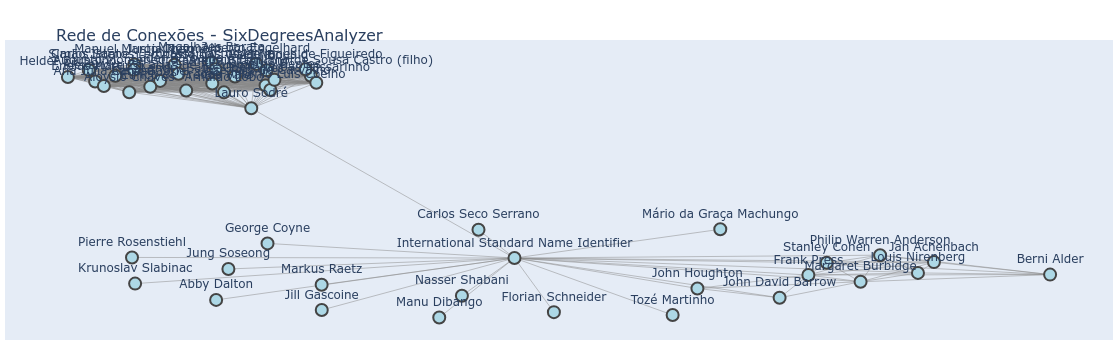

In [19]:
analyzer = SixDegreesAnalyzer()
analyzer.load_biographies_and_connections()

visualizer_simple = SimpleGraphVisualizer(analyzer, max_nodes=50)
fig = visualizer_simple.create_interactive_visualization()
if fig:
    fig.show()